In [2]:
%reload_ext autoreload
%autoreload 2
%reload_ext nb_black

<IPython.core.display.Javascript object>

In [3]:
from pathlib import Path
from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl

<IPython.core.display.Javascript object>

In [4]:
PATH = Path("../input")

<IPython.core.display.Javascript object>

# RainNet ⚡️

## Utils

In [ ]:
def visualize(x, y=None, test=False):
    cmap = plt.cm.get_cmap("RdBu")
    cmap = cmap.reversed()
    if test:
        fig, axes = plt.subplots(1, 4, figsize=(10, 10))
        for i, ax in enumerate(axes):
            img = x[:, :, i]
            ax.imshow(img, cmap=cmap)
    else:
        fig, axes = plt.subplots(1, 5, figsize=(10, 10))
        for i, ax in enumerate(axes[:-1]):
            img = x[:, :, i]
            ax.imshow(img, cmap=cmap)
        axes[-1].imshow(y[:, :, 0], cmap=cmap)
    #     plt.tight_layout()
    plt.show()

## Resize data

In [5]:
(PATH / "train-128").mkdir(exist_ok=True)

<IPython.core.display.Javascript object>

In [21]:
def resize_data(path):
    data = np.load(path)
    img1 = data[:, :, :3]
    img2 = data[:, :, 2:]
    img1 = cv2.copyMakeBorder(img1, 4, 4, 4, 4, cv2.BORDER_REFLECT)
    img2 = cv2.copyMakeBorder(img2, 4, 4, 4, 4, cv2.BORDER_REFLECT)
    img2 = img2[:, :, 1:]
    data = np.concatenate([img1, img2], axis=-1)
    np.save(PATH / "train-128" / path.name, data)


files = list((PATH / "train").glob("*.npy"))
with ThreadPoolExecutor(8) as e:
    e.map(resize_data, files)

<IPython.core.display.Javascript object>

## Dataset

In [5]:
class NowcastingDataset(torch.utils.data.Dataset):
    def __init__(self, paths, test=False):
        self.paths = paths
        self.test = test

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        data = np.load(path)
        x = data[:, :, :4]
        x = x / 255.0
        x = x.astype(np.float32)
        x = torch.tensor(x, dtype=torch.float)
        x = x.permute(2, 0, 1)
        if self.test:
            return x
        else:
            y = data[:, :, 4]
            y = y / 255.0
            y = y.astype(np.float32)
            y = torch.tensor(y, dtype=torch.float)
            y = y.unsqueeze(-1)
            y = y.permute(2, 0, 1)

            return x, y

<IPython.core.display.Javascript object>

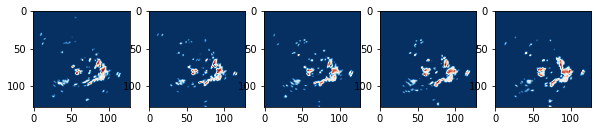

<IPython.core.display.Javascript object>

In [6]:
files = list((PATH / "train-128").glob("*.npy"))
dataset = NowcastingDataset(files)
x, y = dataset[42]
x = x.permute(1, 2, 0).numpy()
y = y.permute(1, 2, 0).numpy()
visualize(x, y)

In [6]:
class NowcastingDataModule(pl.LightningDataModule):
    def __init__(self, df, fold, batch_size, test=False, num_workers=4):
        super().__init__()
        self.df = df
        self.fold = fold
        self.test = test
        self.batch_size = batch_size
        self.num_workers = 4

    def setup(self, stage="train"):
        if stage == "train":
            train_df = self.df[self.df.fold != self.fold]
            val_df = self.df[self.df.fold == self.fold]
            train_paths = [PATH / "train-128" / fn for fn in train_df.filename.values]
            val_paths = [PATH / "train-128" / fn for fn in val_df.filename.values]
            self.train_dataset = NowcastingDataset(train_paths)
            self.val_dataset = NowcastingDataset(val_paths)
        else:
            test_paths = list((PATH / "test").glob("*.npy"))
            self.test_dataset = NowcastingDataset(test_paths, test=True)

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            pin_memory=True,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.val_dataset,
            batch_size=2 * self.batch_size,
            pin_memory=True,
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.test_dataset,
            batch_size=2 * self.batch_size,
            pin_memory=True,
            num_workers=self.num_workers,
        )

<IPython.core.display.Javascript object>

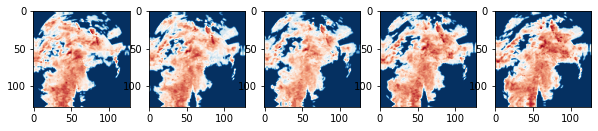

<IPython.core.display.Javascript object>

In [25]:
df = pd.read_csv(PATH / "train_folds.csv")
dm = NowcastingDataModule(df, fold=0, batch_size=32)
dm.setup()
for batch in dm.train_dataloader():
    xs, ys = batch
    x, y = xs[0], ys[0]
    x = x.permute(1, 2, 0).numpy()
    y = y.permute(1, 2, 0).numpy()
    visualize(x, y)
    break

## Model

### RainNet

In [18]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, bn=True):
        super().__init__()
        if bn:
            self.net = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            )
        else:
            self.net = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            )

    def forward(self, x):
        return self.net(x)

<IPython.core.display.Javascript object>

In [19]:
class Encoder(nn.Module):
    def __init__(self, chs=[4, 64, 128, 256, 512, 1024], bn=True):
        super().__init__()
        self.blocks = nn.ModuleList(
            [Block(chs[i], chs[i + 1], bn=bn) for i in range(len(chs) - 1)]
        )
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        ftrs = []
        for block in self.blocks:
            x = block(x)
            ftrs.append(x)
            x = self.pool(x)
        return ftrs

<IPython.core.display.Javascript object>

In [20]:
class Decoder(nn.Module):
    def __init__(self, chs=[1024, 512, 256, 128, 64], bn=True):
        super().__init__()
        self.chs = chs
        self.tr_convs = nn.ModuleList(
            [
                nn.ConvTranspose2d(chs[i], chs[i], kernel_size=2, stride=2)
                for i in range(len(chs) - 1)
            ]
        )
        self.convs = nn.ModuleList(
            [Block(chs[i] + chs[i + 1], chs[i + 1], bn=bn) for i in range(len(chs) - 1)]
        )

    def forward(self, x, ftrs):
        for i in range(len(self.chs) - 1):
            x = self.tr_convs[i](x)
            ftr = ftrs[i]
            x = torch.cat([ftr, x], dim=1)
            x = self.convs[i](x)
        return x

<IPython.core.display.Javascript object>

In [21]:
for ftr in ftrs[::-1][1:]:
    print(ftr.shape)

torch.Size([3, 512, 16, 16])
torch.Size([3, 256, 32, 32])
torch.Size([3, 128, 64, 64])
torch.Size([3, 64, 128, 128])


<IPython.core.display.Javascript object>

In [22]:
dec = Decoder()
x = torch.randn(3, 1024, 8, 8)
dec(x, ftrs=ftrs[::-1][1:]).shape

torch.Size([3, 64, 128, 128])

<IPython.core.display.Javascript object>

In [23]:
class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, inp, targ, epsilon=1e-12):
        e = inp - targ
        return torch.mean(torch.log(torch.cosh(e + episilon)))

<IPython.core.display.Javascript object>

In [24]:
class RainNet(pl.LightningModule):
    def __init__(
        self,
        lr=1e-4,
        bn=True,
        enc_chs=[4, 64, 128, 256, 512, 1024],
        dec_chs=[1024, 512, 256, 128, 64],
    ):
        super().__init__()
        self.save_hyperparameters()
        self.criterion = LogCoshLoss()
        self.encoder = Encoder(enc_chs, bn=bn)
        self.decoder = Decoder(dec_chs, bn=bn)
        if bn:
            self.out = nn.Sequential(
                nn.Conv2d(64, 2, kernel_size=3, bias=False, padding=1),
                nn.BatchNorm2d(2),
                nn.ReLU(inplace=True),
                nn.Conv2d(2, 1, kernel_size=1, bias=False),
                nn.BatchNorm2d(1),
                nn.ReLU(inplace=True),
            )
        else:
            self.out = nn.Sequential(
                nn.Conv2d(64, 2, kernel_size=3, bias=False, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(2, 1, kernel_size=1, bias=False),
                nn.ReLU(inplace=True),
            )

    def forward(self, x):
        ftrs = self.encoder(x)
        ftrs = list(reversed(ftrs))
        x = self.decoder(ftrs[0], ftrs[1:])
        out = self.out(x)
        return out

    def training_step(self, batch, batch_idx):
        loss = self._shared_step()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._shared_step(batch, batch_idx)
        self.log("val_loss", loss)

    def _shared_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.paramters(), lr=self.hparams.lr)
        return optimizer

<IPython.core.display.Javascript object>

In [25]:
model = RainNet()
x = torch.randn(3, 4, 128, 128)
model(x).shape

torch.Size([3, 1, 128, 128])

<IPython.core.display.Javascript object>

In [18]:
class RainNet(pl.LightningModule):
    def __init__(self, lr: float = 1e-4):
        super().__init__()
        self.save_hyperparameters()
        
        self.criterion = LogCoshLoss()

        # Layers
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder layers
        self.down1 = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, bias=False, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
        )
        self.down2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.down4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
        )
        self.down5 = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
        )

        # Decoder layers
        self.upsample6 = nn.ConvTranspose2d(1024, 1024, kernel_size=2, stride=2)
        self.uconv6 = nn.Sequential(
            nn.Conv2d(1024 + 512, 512, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
        )
        self.upsample7 = nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2)
        self.uconv7 = nn.Sequential(
            nn.Conv2d(512 + 256, 256, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
        )
        self.upsample8 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2)
        self.uconv8 = nn.Sequential(
            nn.Conv2d(256 + 128, 128, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
        )
        self.upsample9 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2)
        self.uconv9 = nn.Sequential(
            nn.Conv2d(128 + 64, 64, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
        )
        
        self.out = nn.Sequential(
            nn.Conv2d(64, 2, kernel_size=3, bias=False, padding=1),
            nn.BatchNorm2d(2),
            nn.ReLU(inplace=True),
            nn.Conv2d(2, 1, kernel_size=1, bias=False),
            nn.BatchNorm2d(1),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        conv1 = self.down1(x)
        pool1 = self.pool(conv1)

        conv2 = self.down2(pool1)
        pool2 = self.pool(conv2)

        conv3 = self.down3(pool2)
        pool3 = self.pool(conv3)

        conv4 = self.down4(pool3)
        pool4 = self.pool(conv4)

        conv5 = self.down5(pool4)

        up6 = self.upsample6(conv5)
        up6 = torch.cat([up6, conv4], dim=1)
        conv6 = self.uconv6(up6)

        up7 = self.upsample7(conv6)
        up7 = torch.cat([up7, conv3], dim=1)
        conv7 = self.uconv7(up7)

        up8 = self.upsample8(conv7)
        up8 = torch.cat([up8, conv2], dim=1)
        conv8 = self.uconv8(up8)

        up9 = self.upsample9(conv8)
        up9 = torch.cat([up9, conv1], dim=1)
        conv9 = self.uconv9(up9)

        out = self.out(conv9)

        return out

    def training_step(self, batch, batch_idx):
        loss = self.shared_step()
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.shared_step(batch, batch_idx)
        self.log("val_loss", loss)

    def shared_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.paramters(), lr=self.hparams.lr)
        return optimizer

<IPython.core.display.Javascript object>

In [19]:
model = RainNet()
x = torch.randn(3, 4, 128, 128)
model(x).shape

torch.Size([3, 1, 128, 128])

<IPython.core.display.Javascript object>

In [ ]:
trainer = pl.Trainer(gpus=1, max_epochs=3, progress_bar_refresh_rate=20)